In [1]:
import pandas as pd
import numpy as np
# Pretty display for notebooks
%matplotlib inline

from time import time
from IPython.display import display 

# Read the train and test data
train = pd.read_csv('census.csv')
test = pd.read_csv('test_census.csv', index_col=[0])

In [2]:
# Print train and test columns
print('Train columns:', train.columns.tolist())
print('Test columns:', test.columns.tolist())

Train columns: ['age', 'workclass', 'education_level', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Test columns: ['age', 'workclass', 'education_level', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


Remember, that the test dataset generally contains one column less than the train one.

> Get familiar with the expected output.

In [3]:
# Read the sample submission file
sample_submission = pd.read_csv('example_submission.csv')

# Look at the head() of the sample submission
print(sample_submission.head())

   id  income
0   0       1
1   1       1
2   2       1
3   3       1
4   4       1


The sample submission file consists of two columns: id of the observation and income column for your predictions. Kaggle will evaluate your predictions on the true income data for the corresponding id. So, it’s important to keep track of the predictions by id before submitting them. 

## Fist Determine the problem type

Before building a model, you should determine the problem type you are addressing. Look at the distribution of the target variable, and select the correct problem type you will be building a model for

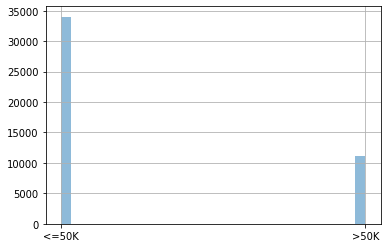

In [4]:
import matplotlib.pyplot as plt
# Plot a histogram
train.income.hist(bins=30, alpha=0.5)
plt.show()

we can see it is a classification problem, as output is categorical (either <=50k or >50k) 
- If continous, the regression problem

In [5]:
# Split the data into features and target label
income_raw = train['income']
features_raw = train.drop('income', axis = 1)

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [8]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == ">50K" else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


In [10]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = start - end
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=10)
clf_B = GradientBoostingClassifier(random_state=10)
clf_C = xgb.XGBClassifier(random_state=10)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
[01:12:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\fardi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 361 samples.
[01:12:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\fardi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 3617 samples.
[01:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\fardi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 36177 samples.


In [12]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import make_scorer, r2_score, fbeta_score

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(random_state=10)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, n_jobs=10)
# grid_obj=RandomizedSearchCV(clf,param_distributions=parameters,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)


# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

KeyboardInterrupt: 

In [ ]:
grid_fit.best_estimator_

In [ ]:
grid_fit.best_params_

In [49]:
# xg_clf = xgb.XGBClassifier(learning_rate = 0.2, 
                            n_estimators = 400,
                           min_child_weight= 1,
                           max_depth = 5,
                           gamma = 0.2,
                           max_delta_step = 1,
                           colsample_bytree= 0.4)

In [51]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, preds))
print("AUC: ", roc_auc_score(y_test, xg_clf.predict_proba(X_test)[:,1]))

[00:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8725262576008844
AUC:  0.9304468181034596


##  Submission

In [52]:
test.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States


In [54]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = test)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

In [55]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.054795,Private,10th,0.333333,Married-civ-spouse,Craft-repair,Husband,White,Male,0.73768,0.0,0.397959,United-States
1,0.438356,Private,Bachelors,0.800000,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.00000,0.0,0.397959,United-States
2,0.369863,Self-emp-not-inc,Assoc-acdm,0.733333,Married-civ-spouse,Other-service,Wife,White,Female,0.00000,0.0,1.000000,United-States
3,0.232877,Private,Bachelors,0.800000,Married-civ-spouse,Sales,Husband,White,Male,0.00000,0.0,0.459184,United-States
4,0.095890,Private,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.00000,0.0,0.397959,United-States


In [56]:
features_final = pd.get_dummies(features_log_minmax_transform)

In [57]:
xg_preds = xg_clf.predict_proba(features_final)[:, 1]


In [58]:
final = pd.DataFrame(list(xg_preds), columns = ['income'])
final = final.reset_index()
final.rename(columns={"index":"id"}, inplace = True)
final.head()

,id,income
0,0,0.006017
1,1,0.772228
2,2,0.228667
3,3,0.781104
4,4,0.045826


In [59]:
final.to_csv('final2.csv', index=False)